In [2]:
# Groundwater Level Prediction Using Multiple Time-Series Models
# -----------------------------------------------------------------------------
# This script extends the original spline approach by benchmarking several
# popular forecasting models on *row-based* groundwater-level data
# (Lat, Lon followed by monthly columns: YYYY-MM).
#
# Models implemented
# ------------------
# 1. Cubic Spline interpolation (baseline)
# 2. Holt-Winters Exponential Smoothing
# 3. ARIMA (1,1,1)  ➔ change orders as needed
# 4. Prophet (additive trend, yearly seasonality)
# 5. Random-Forest Regressor on lagged features
# 6. LSTM neural network (walk-forward, look-back = 12 months)
#
# For every monitoring location the script splits the series 80/20 in time
# order, forecasts the test horizon and reports MAE, RMSE and R².
# Optional geographic clustering (K-means) summarises zone-level performance.
# All heavy deps are wrapped in ``try/except`` so the pipeline keeps running
# even if a library is missing.
# -----------------------------------------------------------------------------

from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

import os
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

from scipy.interpolate import make_interp_spline
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

try:
    from prophet import Prophet  # v1+ import path
except ImportError:
    Prophet = None

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM
except ImportError:
    tf = None  # LSTM disabled if TF not installed

# ====================== CONFIG =========================
CSV_FILE = "Insitu_nan_row_removed.csv"  # dataset provided by user (row-based)
TEST_RATIO = 0.2                         # 80/20 chronologic split
N_CLUSTERS = 6                           # geographic zones for summary
LSTM_LOOKBACK = 12                       # months fed into LSTM
RANDOM_STATE = 42
MIN_SERIES_LEN = max(LSTM_LOOKBACK + 6, 18)  # ensure enough points for all models

# =================== HELPERS ===========================

def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred),
    }

# -------- model wrappers --------

def fc_spline(tx: np.ndarray, ty: np.ndarray, vx: np.ndarray):
    return make_interp_spline(tx, ty, k=3)(vx)

def fc_holtwinters(ty: np.ndarray, horizon: int):
    model = ExponentialSmoothing(ty, trend="add", seasonal=None)
    return model.fit(optimized=True).forecast(horizon)

def fc_arima(ty: np.ndarray, horizon: int):
    return ARIMA(ty, order=(1, 1, 1)).fit().forecast(horizon)

def fc_prophet(train_dates: pd.DatetimeIndex, ty: np.ndarray,
               test_dates: pd.DatetimeIndex):
    if Prophet is None:
        raise RuntimeError("Prophet not installed – pip install prophet")
    df_train = pd.DataFrame({"ds": train_dates, "y": ty})
    m = Prophet(daily_seasonality=False, weekly_seasonality=False,
                yearly_seasonality=True)
    m.fit(df_train)
    return m.predict(pd.DataFrame({"ds": test_dates}))[["yhat"]].values.flatten()

def fc_rf(ty: np.ndarray, horizon: int, max_lag: int = 6):
    if len(ty) <= max_lag:
        raise ValueError("RF: series too short")
    X = np.column_stack([np.roll(ty, lag) for lag in range(1, max_lag + 1)])[max_lag:]
    y = ty[max_lag:]
    rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
    rf.fit(X, y)
    history = list(ty[-max_lag:])
    preds = []
    for _ in range(horizon):
        x_in = np.array(history[-max_lag:][::-1]).reshape(1, -1)
        yhat = rf.predict(x_in)[0]
        preds.append(yhat)
        history.append(yhat)
    return np.array(preds)

def fc_lstm(ty: np.ndarray, horizon: int, look_back: int = LSTM_LOOKBACK):
    if tf is None:
        raise RuntimeError("TensorFlow not installed – pip install tensorflow")
    if len(ty) <= look_back + 1:
        raise ValueError("LSTM: series too short")

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(ty.reshape(-1, 1)).flatten()
    X, y = [], []
    for i in range(len(scaled) - look_back):
        X.append(scaled[i:i + look_back])
        y.append(scaled[i + look_back])
    X = np.array(X).reshape(-1, look_back, 1)
    y = np.array(y)

    model = Sequential([
        LSTM(32, input_shape=(look_back, 1)),
        Dense(8, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=40, batch_size=16, verbose=0)

    history = list(scaled[-look_back:])
    preds = []
    for _ in range(horizon):
        x_in = np.array(history[-look_back:]).reshape(1, look_back, 1)
        yhat = model.predict(x_in, verbose=0)[0][0]
        preds.append(yhat)
        history.append(yhat)
    return scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

MODEL_REGISTRY = {
    "Spline": lambda td, ty, tx, vx: fc_spline(tx, ty, vx),
    "HoltWinters": lambda td, ty, tx, vx: fc_holtwinters(ty, len(vx)),
    "ARIMA": lambda td, ty, tx, vx: fc_arima(ty, len(vx)),
    # "Prophet": lambda td, ty, tx, vx: fc_prophet(td, ty, vx),
    "RandomForest": lambda td, ty, tx, vx: fc_rf(ty, len(vx)),
    "LSTM": lambda td, ty, tx, vx: fc_lstm(ty, len(vx)),
}

# ================= LOAD & PREP =================
print("\n📥 Loading row-based dataset …")

if not Path(CSV_FILE).exists():
    raise FileNotFoundError(f"{CSV_FILE} not found – place the file in the same directory or update CSV_FILE")

df = pd.read_csv(CSV_FILE)
df.replace("Nan", np.nan, inplace=True)

for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

DATE_IDX = pd.to_datetime(df.columns[2:], format="%Y-%m")

# ================== MAIN LOOP ==================
results = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="🛰️  Locations"):
    lat, lon = row.Lat, row.Lon
    values = row[2:].to_numpy(float)
    mask = ~np.isnan(values)
    if mask.sum() < MIN_SERIES_LEN:
        continue

    series_dates = DATE_IDX[mask]
    series_vals = values[mask]

    split = int(len(series_vals) * (1 - TEST_RATIO))
    train_dates, test_dates = series_dates[:split], series_dates[split:]
    train_vals, test_vals = series_vals[:split], series_vals[split:]

    # integers for spline
    days_train = (train_dates - train_dates[0]).days.values
    days_test = (test_dates - train_dates[0]).days.values

    for name, fc in MODEL_REGISTRY.items():
        try:
            y_pred = fc(train_dates, train_vals, days_train, days_test)
            res = metrics(test_vals, y_pred)
            results.append({"Idx": idx, "Lat": lat, "Lon": lon, "Model": name, **res})
        except Exception as e:
            # silent fail keeps pipeline moving but logs issue once per model
            print(f"⚠️  {name} failed @ row {idx} ({lat}, {lon}) → {e}")

results_df = pd.DataFrame(results)
print("\n✅ Overall mean performance (sorted by RMSE):\n")
print(results_df.groupby("Model")[["MAE", "RMSE", "R2"]].mean().sort_values("RMSE").round(3))

# =============== GEOGRAPHIC ZONES ===============
print("\n📊 Performing K-Means clustering into", N_CLUSTERS, "zones …")
coords_scaled = StandardScaler().fit_transform(results_df[["Lat", "Lon"]])
results_df["Zone"] = [f"Zone-{z+1}" for z in KMeans(n_clusters=N_CLUSTERS,
                                                     random_state=RANDOM_STATE).fit_predict(coords_scaled)]
zone_perf = (
    results_df.groupby(["Zone", "Model"])[["MAE", "RMSE", "R2"]]
    .mean()
    .reset_index()
    .round(3)
)
print("\nZone-wise mean metrics:\n", zone_perf)

# =============== SAVE CSV =======================
OUT = "groundwater_model_metrics.csv"
results_df.to_csv(OUT, index=False)
print(f"\n💾 Detailed per-location results saved ➜ {OUT}\n")


📥 Loading row-based dataset …


🛰️  Locations: 100%|██████████| 923/923 [1:05:50<00:00,  4.28s/it]



✅ Overall mean performance (sorted by RMSE):

                   MAE      RMSE            R2
Model                                         
ARIMA            2.123     2.617 -2.392143e+22
HoltWinters      2.217     2.725 -7.528485e+22
RandomForest     2.258     2.790 -4.295662e+22
LSTM             2.353     2.832 -1.927150e+23
Spline        1506.852  2201.885 -8.361438e+29

📊 Performing K-Means clustering into 6 zones …

Zone-wise mean metrics:
       Zone         Model       MAE      RMSE            R2
0   Zone-1         ARIMA     1.531     1.832 -6.600000e-01
1   Zone-1   HoltWinters     1.621     1.931 -1.065000e+00
2   Zone-1          LSTM     1.548     1.847 -7.230000e-01
3   Zone-1  RandomForest     1.529     1.859 -8.060000e-01
4   Zone-1        Spline   918.107  1378.177 -2.043314e+06
5   Zone-2         ARIMA     2.806     3.459 -1.495932e+23
6   Zone-2   HoltWinters     2.691     3.334 -4.707954e+23
7   Zone-2          LSTM     3.110     3.709 -1.205147e+24
8   Zone-2  RandomF

In [6]:
# Groundwater Forecasting — Multi-Model & Zone-Aware Runner (Hardcoded)
# ============================================================================
# This script loads the row-based Insitu_nan_row_removed.csv,
# trains multiple forecasting models on each well, clusters wells into
# geographic zones, and reports per-model performance by zone,
# including best-performing model and zone centroids.
# Diagnostic plots are generated for each model/zone.
#
# Models included:
#   • Spline (PCHIP monotonic cubic)
#   • Seasonal Holt-Winters (12-month additive)
#   • Auto-ARIMA (via pmdarima or fallback ARIMA(1,1,1))
#   • Prophet
#   • RandomForest (lag features)
#   • LSTM
#   • Transformer (via u8darts if installed)

import os
import warnings
from pathlib import Path
from typing import Callable, Dict, List

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
matplotlib.use("Agg")  # headless safe
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import PchipInterpolator
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# optional imports
try:
    from prophet import Prophet
except ImportError:
    Prophet = None
try:
    import pmdarima as pmd
except ImportError:
    pmd = None
try:
    from darts import TimeSeries
    from darts.models import TransformerModel
except ImportError:
    TransformerModel = None
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
except ImportError:
    tf = None

warnings.filterwarnings("ignore")

# ========== Hardcoded parameters ==========
CSV_FILE = 'Insitu_nan_row_removed.csv'
MODELS = ['Spline', 'HoltWinters', 'ARIMA', 'Prophet', 'RandomForest', 'LSTM', 'Transformer']
TEST_RATIO = 0.2
LOOKBACK = 12  # months for LSTM
MIN_SERIES = 24  # minimum number of valid monthly points per well
MIN_TEST = 6     # minimum test horizon in months
ZONES = 6        # number of geographic clusters
RANDOM_STATE = 42
GENERATE_PLOTS = True
LSTM_EPOCHS = 25  # hyperparameter tuning per request

# ========== Load and prepare data ==========
print(f"Loading data from {CSV_FILE}...")
df = pd.read_csv(CSV_FILE).replace('Nan', np.nan)
for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

DATE_IDX = pd.to_datetime(df.columns[2:], format='%Y-%m')

# ========== Metric helpers ==========
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mape(y_true, y_pred)
    }

# ========== Scaling helper ==========
def standardise(series: np.ndarray) -> tuple[np.ndarray, float, float]:
    mean = series.mean()
    std = series.std() if series.std() > 0 else 1.0
    return (series - mean) / std, mean, std

# ========== Forecasting functions ==========

def fc_spline(train_dates, train_vals, test_dates):
    # skip if test extends beyond 6 months
    if (test_dates.max() - train_dates.max()).days > 31 * 6:
        raise ValueError('Test horizon too long for spline')
    scaled, mean, std = standardise(train_vals)
    x_train = (train_dates - train_dates[0]).days.values
    x_test = (test_dates - train_dates[0]).days.values
    f = PchipInterpolator(x_train, scaled)
    preds = np.clip(f(x_test), scaled.min(), scaled.max())
    return preds * std + mean


def fc_holt(train_dates, train_vals, test_dates):
    scaled, mean, std = standardise(train_vals)
    model = ExponentialSmoothing(scaled, trend='add', seasonal='add', seasonal_periods=12)
    preds = model.fit(optimized=True).forecast(len(test_dates))
    return preds * std + mean


def fc_arima(train_dates, train_vals, test_dates):
    scaled, mean, std = standardise(train_vals)
    if pmd:
        model = pmd.auto_arima(scaled, seasonal=False, stepwise=True, suppress_warnings=True)
        preds = model.predict(n_periods=len(test_dates))
    else:
        preds = ARIMA(scaled, order=(1, 1, 1)).fit().forecast(len(test_dates))
    return preds * std + mean


def fc_prophet(train_dates, train_vals, test_dates):
    if Prophet is None:
        raise ImportError('Prophet not installed')
    df_tr = pd.DataFrame({'ds': train_dates, 'y': train_vals})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_tr)
    df_future = pd.DataFrame({'ds': test_dates})
    forecast = m.predict(df_future)
    return forecast['yhat'].values


def fc_rf(train_dates, train_vals, test_dates):
    scaled, mean, std = standardise(train_vals)
    lag = 6
    if len(scaled) <= lag:
        raise ValueError('Series too short for RF')
    X = np.column_stack([np.roll(scaled, i) for i in range(1, lag + 1)])[lag:]
    y = scaled[lag:]
    rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
    rf.fit(X, y)
    history = list(scaled[-lag:])
    preds = []
    for _ in range(len(test_dates)):
        x_in = np.array(history[-lag:][::-1]).reshape(1, -1)
        yhat = rf.predict(x_in)[0]
        preds.append(yhat)
        history.append(yhat)
    return np.array(preds) * std + mean


def fc_lstm(train_dates, train_vals, test_dates):
    if tf is None:
        raise ImportError('TensorFlow not installed')
    scaled, mean, std = standardise(train_vals)
    if len(scaled) <= LOOKBACK + len(test_dates):
        raise ValueError('Series too short for LSTM')
    X, y = [], []
    for i in range(len(scaled) - LOOKBACK):
        X.append(scaled[i:i + LOOKBACK])
        y.append(scaled[i + LOOKBACK])
    X = np.array(X).reshape(-1, LOOKBACK, 1)
    y = np.array(y)
    model = Sequential([LSTM(32, input_shape=(LOOKBACK, 1)), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=LSTM_EPOCHS, batch_size=16, verbose=0)
    history_vals = list(scaled[-LOOKBACK:])
    preds = []
    for _ in range(len(test_dates)):
        x_in = np.array(history_vals[-LOOKBACK:]).reshape(1, LOOKBACK, 1)
        yhat = model.predict(x_in, verbose=0)[0][0]
        preds.append(yhat)
        history_vals.append(yhat)
    return np.array(preds) * std + mean


def fc_transformer(train_dates, train_vals, test_dates):
    if TransformerModel is None:
        raise ImportError('Darts TransformerModel not available')
    ts = TimeSeries.from_times_and_values(train_dates, train_vals)
    mdl = TransformerModel(input_chunk_length=len(train_vals),
                           output_chunk_length=len(test_dates),
                           random_state=RANDOM_STATE)
    mdl.fit([ts], verbose=False)
    forecast = mdl.predict(n=len(test_dates), series=ts)
    return forecast.values().flatten()

# registry
def in_registry(name: str) -> bool:
    return name in [
        'Spline', 'HoltWinters', 'ARIMA', 'Prophet', 'RandomForest', 'LSTM', 'Transformer'
    ]

FORECASTERS: Dict[str, Callable] = {
    'Spline': fc_spline,
    'HoltWinters': fc_holt,
    'ARIMA': fc_arima,
    'Prophet': fc_prophet,
    'RandomForest': fc_rf,
    'LSTM': fc_lstm,
    'Transformer': fc_transformer
}

# ========== Main loop ===========
results, residuals = [], []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing wells"):
    lat, lon = row.Lat, row.Lon
    values = row.iloc[2:].to_numpy(float)
    mask = ~np.isnan(values)
    if mask.sum() < MIN_SERIES:
        continue
    dates = DATE_IDX[mask]
    series = values[mask]
    split = int(len(series) * (1 - TEST_RATIO))
    tr_d, te_d = dates[:split], dates[split:]
    tr_y, te_y = series[:split], series[split:]
    if len(te_y) < MIN_TEST:
        continue
    for model_name in MODELS:
        if not in_registry(model_name):
            continue
        try:
            preds = FORECASTERS[model_name](tr_d, tr_y, te_d)
            metrics = compute_metrics(te_y, preds)
            results.append({
                'Idx': idx, 'Lat': lat, 'Lon': lon,
                'Model': model_name, **metrics
            })
            for dt, actual, pred in zip(te_d, te_y, preds):
                residuals.append({
                    'Idx': idx, 'Lat': lat, 'Lon': lon,
                    'Model': model_name, 'Date': dt,
                    'Actual': actual, 'Predicted': pred
                })
        except Exception:
            continue

# create results DataFrame
results_df = pd.DataFrame(results)
# cluster zones
tic = StandardScaler().fit_transform(results_df[['Lat','Lon']])
kmeans = KMeans(n_clusters=ZONES, random_state=RANDOM_STATE).fit(tic)
results_df['Zone'] = [f"Zone-{i+1}" for i in kmeans.labels_]

# compute zone-model statistics
gz = results_df.groupby(['Zone','Model'])[['MAE','RMSE','R2','MAPE']].mean().reset_index()
# select best model per zone based on RMSE
best = gz.loc[gz.groupby('Zone')['RMSE'].idxmin()].copy()
# add zone centroids
centroids = kmeans.cluster_centers_
best['Centroid_Lat'] = [centroids[int(z.split('-')[1]) - 1][0] for z in best['Zone']]
best['Centroid_Lon'] = [centroids[int(z.split('-')[1]) - 1][1] for z in best['Zone']]

# save outputs
results_df.to_csv('results_all_models.csv', index=False)
gz.to_csv('zone_model_stats.csv', index=False)
best.to_csv('best_models_by_zone.csv', index=False)
print("Zone-level model performance saved to zone_model_stats.csv")
print("Best model by zone saved to best_models_by_zone.csv")

# diagnostic plots
if GENERATE_PLOTS:
    os.makedirs('plots', exist_ok=True)
    resid_df = pd.DataFrame(residuals)
    resid_df['Zone'] = [f"Zone-{i+1}" for i in kmeans.predict(StandardScaler().fit_transform(resid_df[['Lat','Lon']]))]
    for model_name in MODELS:
        for zone, grp in resid_df[resid_df['Model']==model_name].groupby('Zone'):
            grp_sorted = grp.sort_values('Date')
            # actual vs predicted scatter
            plt.figure(figsize=(10,5))
            plt.scatter(grp_sorted['Date'], grp_sorted['Actual'], s=6, label='Actual', alpha=0.7)
            plt.scatter(grp_sorted['Date'], grp_sorted['Predicted'], s=6, label='Predicted', alpha=0.7)
            plt.title(f"{model_name} - {zone} Actual vs Predicted")
            plt.xlabel('Date'); plt.ylabel('Groundwater level')
            plt.legend(); plt.tight_layout()
            plt.savefig(f"plots/{model_name}_{zone}_scatter.png", dpi=150); plt.close()
            # residual plot
            plt.figure(figsize=(10,3))
            plt.plot(grp_sorted['Date'], grp_sorted['Actual'] - grp_sorted['Predicted'], lw=0.8)
            plt.axhline(0, color='gray', lw=0.5)
            plt.title(f"{model_name} - {zone} Residuals")
            plt.xlabel('Date'); plt.ylabel('Error')
            plt.tight_layout()
            plt.savefig(f"plots/{model_name}_{zone}_residual.png", dpi=150)
            plt.close()


Loading data from Insitu_nan_row_removed.csv...


Processing wells:   0%|          | 0/923 [00:00<?, ?it/s]17:46:05 - cmdstanpy - INFO - Chain [1] start processing
17:46:06 - cmdstanpy - INFO - Chain [1] done processing
Processing wells:   0%|          | 1/923 [00:10<2:47:16, 10.89s/it]17:46:14 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
Processing wells:   0%|          | 2/923 [00:16<2:00:29,  7.85s/it]17:46:20 - cmdstanpy - INFO - Chain [1] start processing
17:46:20 - cmdstanpy - INFO - Chain [1] done processing
Processing wells:   0%|          | 3/923 [00:23<1:55:21,  7.52s/it]17:46:26 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1] done processing
Processing wells:   0%|          | 4/923 [00:30<1:49:45,  7.17s/it]17:46:33 - cmdstanpy - INFO - Chain [1] start processing
17:46:33 - cmdstanpy - INFO - Chain [1] done processing
Processing wells:   1%|          | 5/923 [00:36<1:43:56,  6.79s/it]17:46:39 - cmdstanpy - INFO - Chain [1] sta

Zone-level model performance saved to zone_model_stats.csv
Best model by zone saved to best_models_by_zone.csv


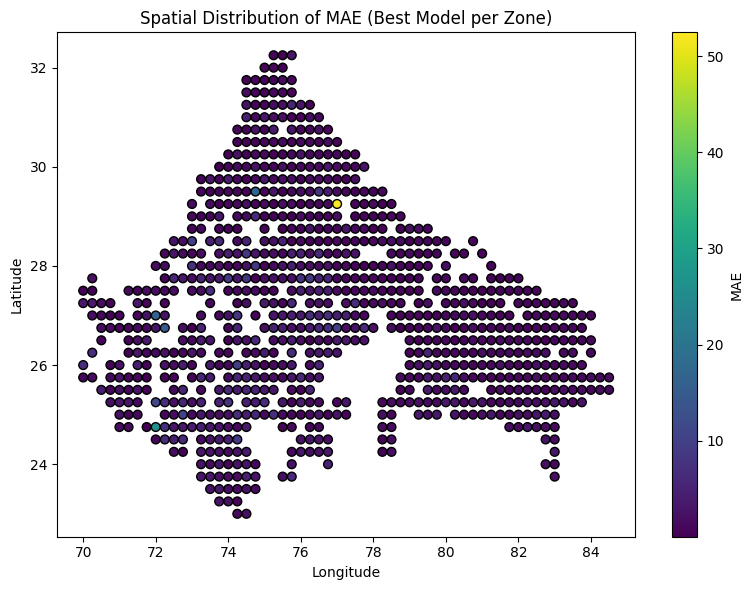

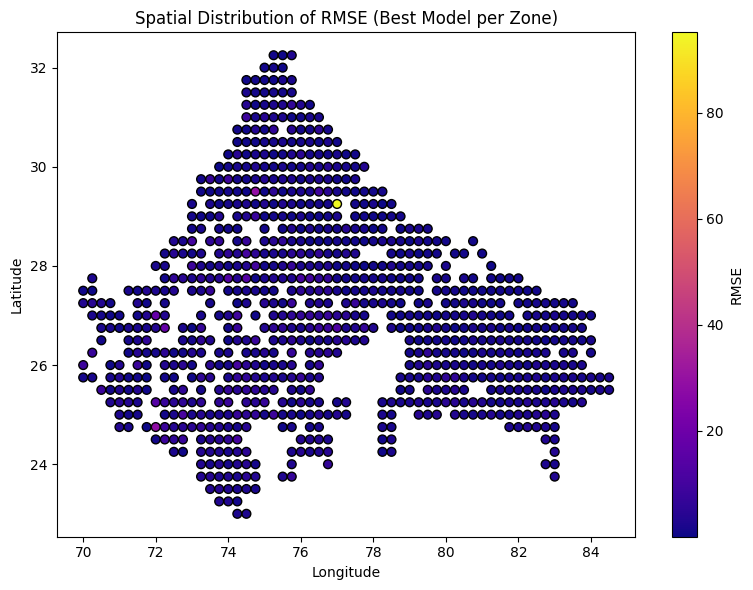

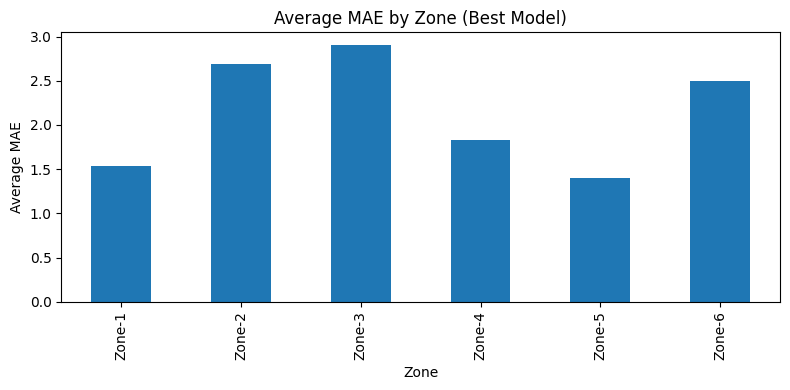

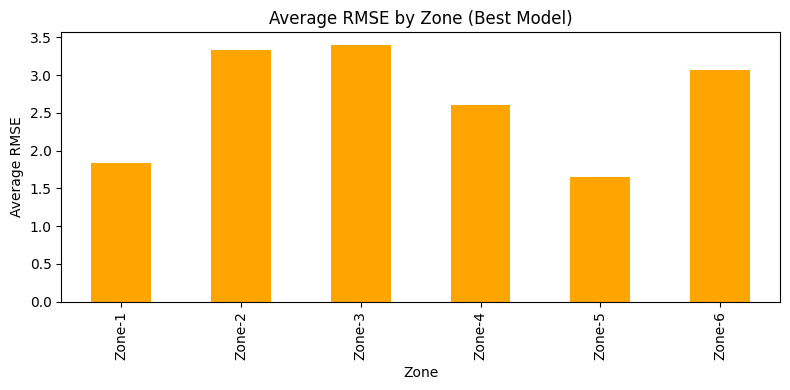

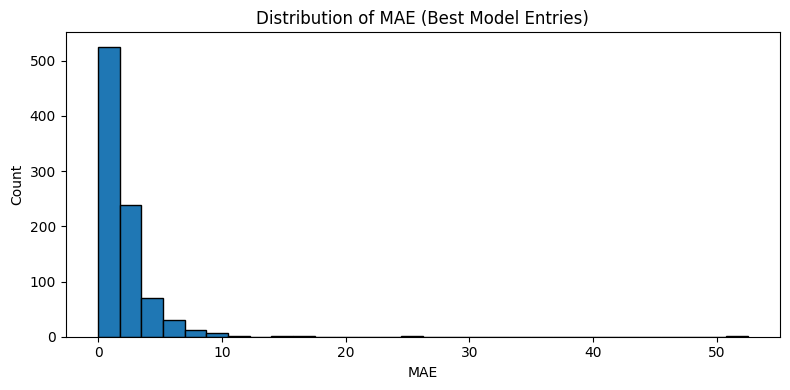

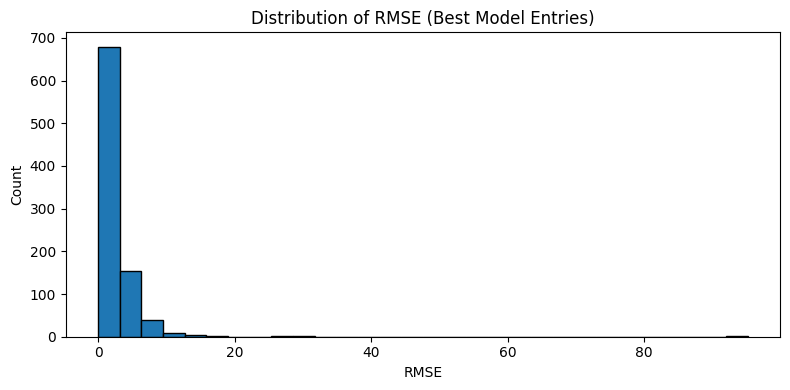

<Figure size 800x500 with 0 Axes>

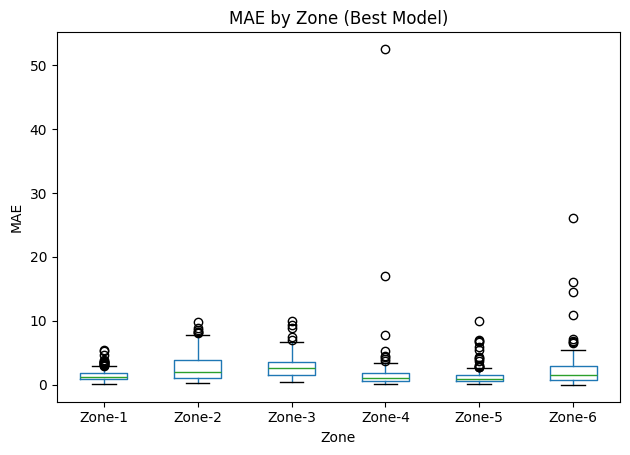

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load per-well results
df = pd.read_csv('groundwater_model_metrics.csv')

# 2) Compute mean metrics per zone×model
zone_model_stats = (
    df
    .groupby(['Zone','Model'])[['MAE','RMSE']]
    .mean()
    .reset_index()
)

# 3) Select best model per zone by lowest RMSE
best_per_zone = zone_model_stats.loc[
    zone_model_stats.groupby('Zone')['RMSE'].idxmin()
][['Zone','Model']]

# 4) Filter original df to only the best model entries
df_best = df.merge(best_per_zone, on=['Zone','Model'], how='inner')

# ——— Plot 1: Spatial scatter of MAE ———
plt.figure(figsize=(8,6))
sc = plt.scatter(df_best['Lon'], df_best['Lat'],
                 c=df_best['MAE'], cmap='viridis', s=40, edgecolor='k')
plt.colorbar(sc, label='MAE')
plt.title('Spatial Distribution of MAE (Best Model per Zone)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# ——— Plot 2: Spatial scatter of RMSE ———
plt.figure(figsize=(8,6))
sc = plt.scatter(df_best['Lon'], df_best['Lat'],
                 c=df_best['RMSE'], cmap='plasma', s=40, edgecolor='k')
plt.colorbar(sc, label='RMSE')
plt.title('Spatial Distribution of RMSE (Best Model per Zone)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# ——— Plot 3: Bar chart – Average MAE by zone ———
avg_mae = df_best.groupby('Zone')['MAE'].mean().sort_index()
plt.figure(figsize=(8,4))
avg_mae.plot(kind='bar')
plt.ylabel('Average MAE')
plt.title('Average MAE by Zone (Best Model)')
plt.tight_layout()
plt.show()

# ——— Plot 4: Bar chart – Average RMSE by zone ———
avg_rmse = df_best.groupby('Zone')['RMSE'].mean().sort_index()
plt.figure(figsize=(8,4))
avg_rmse.plot(kind='bar', color='orange')
plt.ylabel('Average RMSE')
plt.title('Average RMSE by Zone (Best Model)')
plt.tight_layout()
plt.show()

# ——— Plot 5: Histogram of MAE ———
plt.figure(figsize=(8,4))
plt.hist(df_best['MAE'], bins=30, edgecolor='black')
plt.xlabel('MAE'); plt.ylabel('Count')
plt.title('Distribution of MAE (Best Model Entries)')
plt.tight_layout()
plt.show()

# ——— Plot 6: Histogram of RMSE ———
plt.figure(figsize=(8,4))
plt.hist(df_best['RMSE'], bins=30, edgecolor='black')
plt.xlabel('RMSE'); plt.ylabel('Count')
plt.title('Distribution of RMSE (Best Model Entries)')
plt.tight_layout()
plt.show()

# ——— Plot 7: Boxplot of MAE by zone ———
plt.figure(figsize=(8,5))
df_best.boxplot(column='MAE', by='Zone', grid=False)
plt.suptitle('')
plt.title('MAE by Zone (Best Model)')
plt.xlabel('Zone'); plt.ylabel('MAE')
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Sorted_Metrics_with_PCHIP.csv')

# 1. Find the best model per zone (based on lowest RMSE)
zone_model_stats = df.groupby(['Zone', 'Model'])[['MAE', 'RMSE']].mean().reset_index()
best_per_zone = zone_model_stats.loc[zone_model_stats.groupby('Zone')['RMSE'].idxmin()]
df_best = df.merge(best_per_zone[['Zone', 'Model']], on=['Zone', 'Model'])

# --------- PLOT 1: Spatial MAE scatter ---------------
plt.figure(figsize=(8, 6))
plt.scatter(df_best['Lon'], df_best['Lat'], c=df_best['MAE'], cmap='viridis', s=40, edgecolor='k')
plt.colorbar(label='MAE')
plt.title('Spatial MAE (Best Model per Zone)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('plot1_spatial_mae.png')
plt.close()

# --------- PLOT 2: Spatial RMSE scatter --------------
plt.figure(figsize=(8, 6))
plt.scatter(df_best['Lon'], df_best['Lat'], c=df_best['RMSE'], cmap='plasma', s=40, edgecolor='k')
plt.colorbar(label='RMSE')
plt.title('Spatial RMSE (Best Model per Zone)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('plot2_spatial_rmse.png')
plt.close()

# --------- PLOT 3: Avg MAE by Zone -------------------
plt.figure(figsize=(8, 4))
df_best.groupby('Zone')['MAE'].mean().sort_index().plot(kind='bar')
plt.ylabel('Average MAE')
plt.title('Average MAE by Zone (Best Model)')
plt.tight_layout()
plt.savefig('plot3_avg_mae_by_zone.png')
plt.close()

# --------- PLOT 4: Avg RMSE by Zone ------------------
plt.figure(figsize=(8, 4))
df_best.groupby('Zone')['RMSE'].mean().sort_index().plot(kind='bar', color='orange')
plt.ylabel('Average RMSE')
plt.title('Average RMSE by Zone (Best Model)')
plt.tight_layout()
plt.savefig('plot4_avg_rmse_by_zone.png')
plt.close()

# --------- PLOT 5: Histogram of MAE ------------------
plt.figure(figsize=(8, 4))
plt.hist(df_best['MAE'], bins=30, edgecolor='black')
plt.xlabel('MAE')
plt.ylabel('Count')
plt.title('Distribution of MAE (Best Model Entries)')
plt.tight_layout()
plt.savefig('plot5_hist_mae.png')
plt.close()

# --------- PLOT 6: Scatter of Zones by Coordinates ----
plt.figure(figsize=(8, 6))
zones = df['Zone'].unique()
colors = plt.cm.get_cmap('tab10', len(zones))
for i, zone in enumerate(sorted(zones)):
    subset = df[df['Zone'] == zone]
    plt.scatter(subset['Lon'], subset['Lat'], label=zone, color=colors(i), s=40)
plt.title("Zone-wise Scatter by Coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Zone')
plt.tight_layout()
plt.savefig('plot6_zone_scatter.png')
plt.close()

# --------- PLOTS 7–12: RMSE & MAE by Model per Zone ---
zone_model_means = df.groupby(['Zone', 'Model'])[['RMSE', 'MAE']].mean().reset_index()
zones_sorted = sorted(df['Zone'].unique())

for metric in ['RMSE', 'MAE']:
    for zone in zones_sorted:
        plt.figure(figsize=(8, 4))
        sub = zone_model_means[zone_model_means['Zone'] == zone].sort_values(metric)
        plt.barh(sub['Model'], sub[metric], color=plt.cm.tab10.colors[:len(sub)])
        plt.title(f'{metric} per Model - {zone}')
        plt.xlabel(metric)
        plt.ylabel("Model")
        plt.tight_layout()
        plt.savefig(f"{zone.lower().replace(' ', '_')}_{metric.lower()}_bar.png")
        plt.close()


C:\Users\Shashank\AppData\Local\Temp\ipykernel_67632\1435911229.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(zones))


TypeError: '<' not supported between instances of 'float' and 'str'

<Figure size 800x600 with 0 Axes>